In [ ]:
"""参考サイト
https://qiita.com/0NE_shoT_/items/286a99d66cf6d3aaccf0

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

from statsmodels.api import add_constant
from matplotlib import ticker

In [3]:
#岩波書店の傾向スコア用データをインポート
df = pd.read_csv('./q_data_x.csv')
df.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


In [4]:
df.columns

Index(['cm_dummy', 'gamedummy', 'area_kanto', 'area_keihan', 'area_tokai',
       'area_keihanshin', 'age', 'sex', 'marry_dummy', 'job_dummy1',
       'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6',
       'job_dummy7', 'job_dummy8', 'inc', 'pmoney', 'fam_str_dummy1',
       'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4', 'fam_str_dummy5',
       'child_dummy', 'T', 'F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'TVwatch_day',
       'gamesecond', 'gamecount'],
      dtype='object')

In [5]:
#説明変数と目的変数の設定
X = df[['TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc', 'pmoney','area_kanto', 'area_tokai', 'area_keihanshin', 
          'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7',
          'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4']] # 共変量
Z = df['cm_dummy'] # 群別変数

In [6]:
#傾向スコアの付与
exog = sm.add_constant(X)
logit_model = sm.Logit(endog=Z, exog = exog, random_state = 42)
logit_res = logit_model.fit()

ps = logit_res.predict(exog)
print(roc_auc_score(y_true = Z, y_score = ps))

Optimization terminated successfully.
         Current function value: 0.542117
         Iterations 6
0.7917028470947529


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


In [8]:
#傾向スコア&CM視聴有無&アプリインストール有無のデータフレームを作成
ps = pd.Series(ps)
Y = df['gamedummy']

idx1 = pd.Series(df.loc[df['cm_dummy'] == 1, 'gamedummy'].index)
idx0 = pd.Series(df.loc[df['cm_dummy'] == 0, 'gamedummy'].index)

cm_tmp = np.r_[Z[idx1], Z[idx0]]
game_tmp = np.r_[Y[idx1], Y[idx0]]
ps_tmp = np.r_[ps[idx1], ps[idx0]]

In [18]:
#10,000人の傾向スコア（ps）、CM視聴有無フラグ（cm）、アプリインストールフラグ（game）のDataFrame作成
table = pd.DataFrame({'ps':ps_tmp, 'cm':cm_tmp, 'game':game_tmp})
table

,ps,cm,game
0,0.320756,1,0
1,0.404411,1,0
2,0.285624,1,0
3,0.267721,1,0
4,0.231845,1,0
...,...,...,...
9995,0.214722,0,1
9996,0.214755,0,1
9997,0.214745,0,1
9998,0.214743,0,1


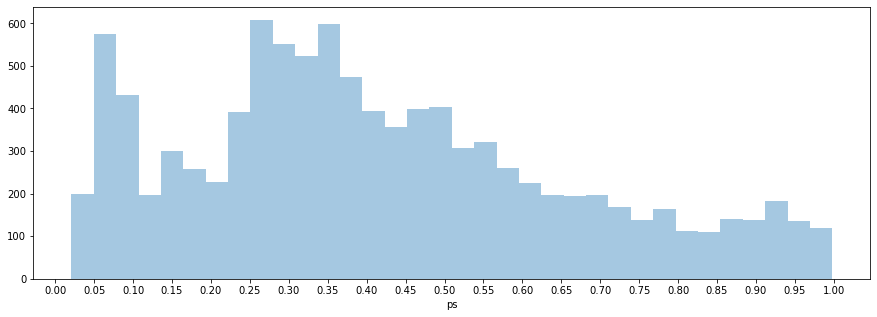

In [13]:
#傾向スコアの可視化:ALL
fig = plt.figure(figsize=(15, 5))
ax = plt.gca()
sns.distplot(table['ps'], kde = False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))

<AxesSubplot:xlabel='ps'>

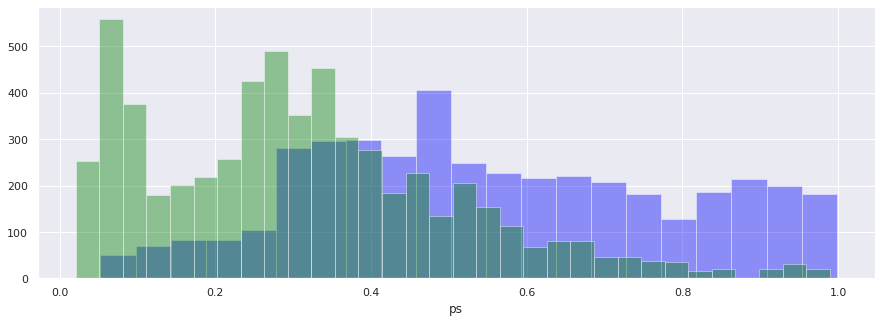

In [15]:
#傾向スコアの可視化:CM接触者と非接触者別
sns.set()
fig, ax = plt.subplots(figsize=(15,5))
#ax.set(ylim=(0,10000))
sns.distplot(table[table['cm'] == 1]['ps'], kde = False, color = 'blue')
sns.distplot(table[table['cm'] == 0]['ps'], kde = False, color = 'green')

In [20]:
#傾向スコア分布の箱ひげ図
#sns.catplot(x=table["cm"], y=table["ps"], kind="box", data=table)

In [23]:
#ATE
ps = ps_tmp
cm = cm_tmp
game = game_tmp

ipwe1 = sum((cm * game) / ps) / sum(cm / ps)
ipwe0 = sum(((1 - cm) * game) / (1 - ps)) / sum((1 - cm) / (1 - ps))
ATE = ipwe1 - ipwe0
ATE

0.031957215682676794

In [25]:
#ATT
w01 = ((1 - cm) * ps) / (1 - ps)
E1 = np.mean(game[cm == 1])
E0 = np.sum(game * w01) / np.sum(w01)
ATT = E1 - E0
ATT

0.025634776452065605

In [ ]:
"""
以下はメモ

# オーバーサンプリング

In [ ]:
#CM接触者と非接触者を1:1にするためにCM非接触者を100,000件抽出する
df_oversample = df[df['cm_flg'] == 0].sample(n = 100000, replace=True, random_state=42)

In [ ]:
#元データdfにオーバーサンプリングしたdf_oversampleを結合
df_merge = pd.concat([df, df_oversample])
df_merge.reset_index(inplace=True, drop=True)

In [ ]:
#Xに説明変数、ZにCM接触フラグ
X = df_merge[['']]
Z = df_merge['cm_flg']

# propensity

In [ ]:
X_res = X

In [ ]:
exog = sm.add_constant(X_res)
logit_model = sm.Logit(endog=Z, exog = exog, random_state = 42)
logit_res = logit_model.fit()

ps = logit_res.predict(exog)
print(roc_auc_score(y_true = Z, y_score = ps))

# Oversampling前のテーブルを作る

In [ ]:
ps_100000 = ps[0:100000]
Z_100000 = df['cm_flg']

In [ ]:
Y = df['raiten_flg']
idx1 = pd.Series(df.loc[df['cm_flg'] == 1, 'raiten_flg'].index)
idx0 = pd.Series(df.loc[df['cm_flg'] == 0, 'raiten_flg'].index)

cm_tmp = np.r_[Z_100000[idx1], Z_100000[idx0]]
raiten_tmp = np.r_[Y[idx1], Y[idx0]]
ps_tmp = np.r_[ps_100000[idx1], ps_100000[idx0]]

table = pd.DataFrame({'ps':ps_tmp, 'cm':cm_tmp, 'raiten_tmp':raiten_tmp})

In [ ]:
#AUCの計算
print(roc_auc_score(y_true=table['cm'], y_score=table['ps']))

# propensityの可視化

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = plt.gca()
sns.distplot(table['ps'], kde = False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.01))

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize=(15,5))
ax.set(ylim=(0,10000))
sns.distplot(table[table['cm'] == 1]['ps'], kde = False, color = 'blue')
sns.distplot(table[table['cm'] == 1]['ps'], kde = False, color = 'green')

# ATE, ATT

In [ ]:
#ATE
ps = ps_tmp
cm = cm_tmp
raiten = raiten_tmp

ipwe1 = sum((cm * raiten) / ps) / sum(cm / ps)
ipwe0 = sum(((1 - cm) * raiten) / (1 - ps)) / sum((1 - cm) / (1 - ps))
ATE = ipwe1 - ipwe0

In [ ]:
#ATT
w01 = ((1 - cm) * ps) / (1 - ps)
E1 = np.mean(raiten[cm == 1])
E0 = np.sum(raiten * w01) / np.sum(w01)
ATT = E01 - E0